In [371]:
#import relevant libraries
import numpy as np
import emcee
import pandas as pd
import matplotlib.pyplot as plt
import corner


In [372]:
#set iPTF16hvw redshit and B band max
z_16hvw = .03663

MJD_max_16hvw = 57714.40

In [373]:
#import the data
g = pd.read_csv('../Data/16hvw_photometry/16hvw_g_forced_flux.txt', sep=" " , header=None)
R = pd.read_csv('../Data/16hvw_photometry/16hvw_R_forced_flux.txt', sep=" " , header=None)

#convert to MJD
g[0] = g[0] - 2400000.5
R[0] = R[0] - 2400000.5

#convert times relative to SN max light in restframe
g[0] = (g[0] - MJD_max_16hvw) / (1 + z_16hvw)
R[0] = (R[0] - MJD_max_16hvw) / (1 +z_16hvw)

#Set column names 
g.columns = ['phase' , 'Flux' ,'Fluxerr']
R.columns =  ['phase' , 'Flux' ,'Fluxerr']


#get rid of bad data
R_bad_indices = np.where(np.logical_or(R['Fluxerr']< 0, R['Flux'] == 99999999.0))
g_bad_indices = np.where(np.logical_or(g['Fluxerr']< 0, g['Flux'] == 99999999.0))

R.drop(index=R_bad_indices[0], inplace=True)
g.drop(index=g_bad_indices[0], inplace=True)

#Get rid of post peak data
g = g[:-4]
R = R[:-4]

In [374]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax


#set parameter names
paramsNames=['a', 
           'b', 't_0', 'alpha', 'sig_0']

# likelihood function

# <center> $\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2}})} exp\bigg(\frac{-(y_{i} - (a + b(t-t_{0})^{\alpha}))}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg) $
</centering>

# <center>$\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2} })} exp\bigg(\frac{-(y_{i} - a )}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg)$
    
   

In [376]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, b, t_0, alpha, sig_0 = theta
    ln_l = 0
    for i in range(len(t)):
        if(t[i] < t_0):
            model = a
        elif(t[i] > t_0):
            model = a + (b*((t[i] - t_0)**alpha))
        ln_l += np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err[i]**2))) - ((f[i] - model)**2 / (2 * (sig_0**2 + f_err[i]**2)))
    return ln_l

#Define priors on parameters  
def lnprior(theta):
    a, b, t_0, alpha, sig_0 = theta
    if(-25 < t_0 < -10 and 0 < alpha < 5 and 0 < sig_0 < 100 and -100 < a < 100 and  0 < b < 100):
        return 0.0
    return -np.inf
   
def posterior(theta, f, t, f_err):
    prior = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(prior):
        return -np.inf
    return lnl + prior
    
   

In [377]:
#initial guess on parameters
guess_0 = [30 , 1 ,-16, 2, 100]



In [319]:
#number of walkers
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=6

#initial position of walkers
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

#create sampler in R band and run it
sampler_R = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(R['Flux']), np.array(R['phase']) , np.array(R['Fluxerr'])), threads = ncores)
nsamples = 10000
foo = sampler_R.run_mcmc(pos, nsamples)

In [320]:
# set a "burn-in" limit
nburn = 4000

#Grab alpha and t_0 samples from all walkers
alpha_samples_R = np.array(sampler_R.chain[:,:nburn,3]).flatten()
t_0_samples_R = np.array(sampler_R.chain[:,:nburn,2]).flatten()

#print the median taking 1-sigma confidence intervals
samples_R = np.vstack([t_0_samples_R, alpha_samples_R]).T

t_0_mc_R, alpha_mc_R = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_R, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_R[0], t_0_mc_R[1], t_0_mc_R[2], alpha_mc_R[0], alpha_mc_R[1], alpha_mc_R[2]))

emcee results with 1-sigma uncertainties
       t_0 = -18.7108 +0.6836 -0.9717
       alpha = 2.1469 +0.5411 -0.3683



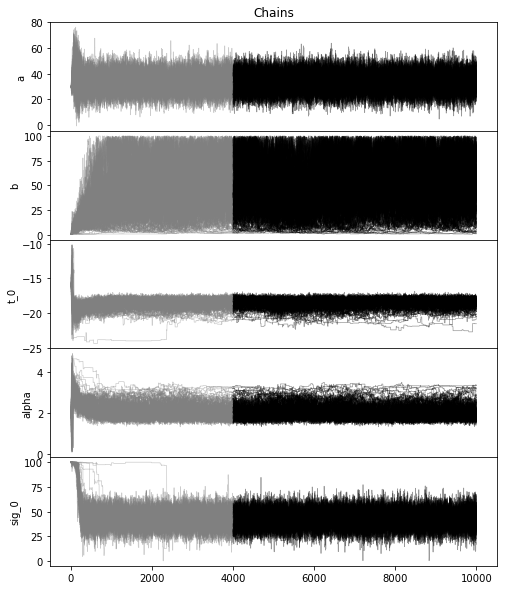

In [321]:
#plot chains
axR = plotChains(sampler_R, nburn, paramsNames)
plt.show()

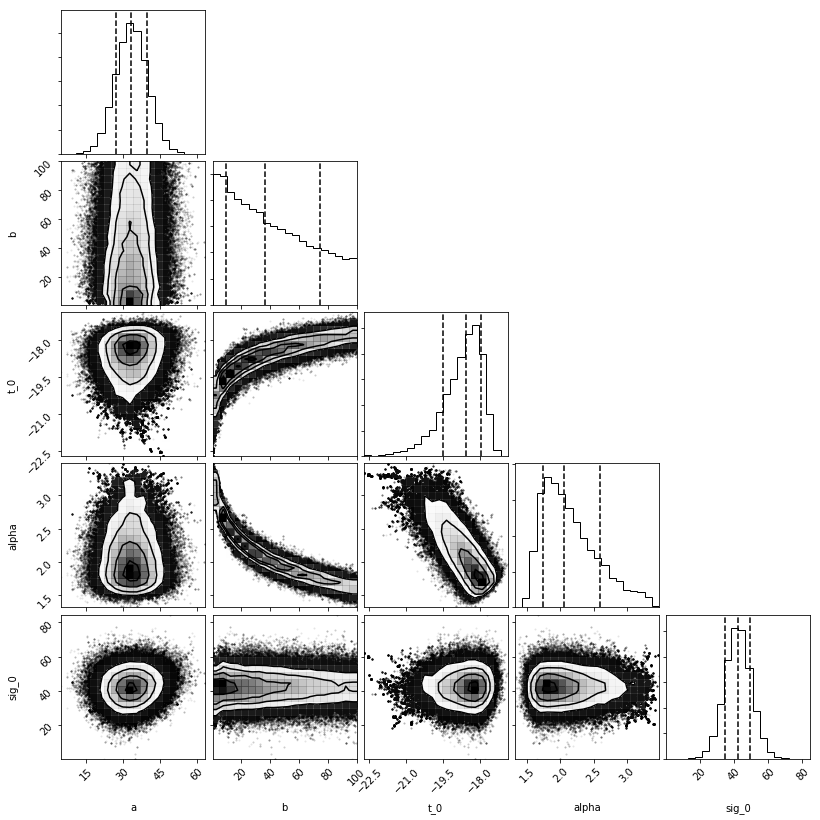

In [322]:
#make corner plot
makeCorner(sampler_R, nburn, paramsNames)
plt.show()

In [378]:
#create sampler in g band and run it
sampler_g = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(g['Flux']), np.array(g['phase']) , np.array(g['Fluxerr'])), threads = ncores)
nsamples = 10000
foo2 = sampler_g.run_mcmc(pos, nsamples)

In [380]:
#Grab alpha and t_0 samples from all walkers
alpha_samples_g = np.array(sampler_g.chain[:,:nburn,3]).flatten()
t_0_samples_g = np.array(sampler_g.chain[:,:nburn,2]).flatten()

#print the median taking 1-sigma confidence intervals
samples_g = np.vstack([t_0_samples_g, alpha_samples_g]).T

t_0_mc_g, alpha_mc_g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_g, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2]))

emcee results with 1-sigma uncertainties
       t_0 = -18.7899 +0.7841 -0.9853
       alpha = 2.2385 +0.5492 -0.4542



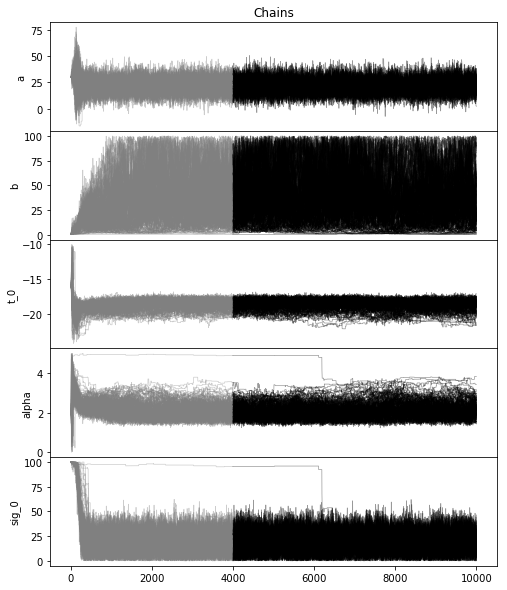

In [381]:
ax = plotChains(sampler_g, nburn, paramsNames)
plt.show()


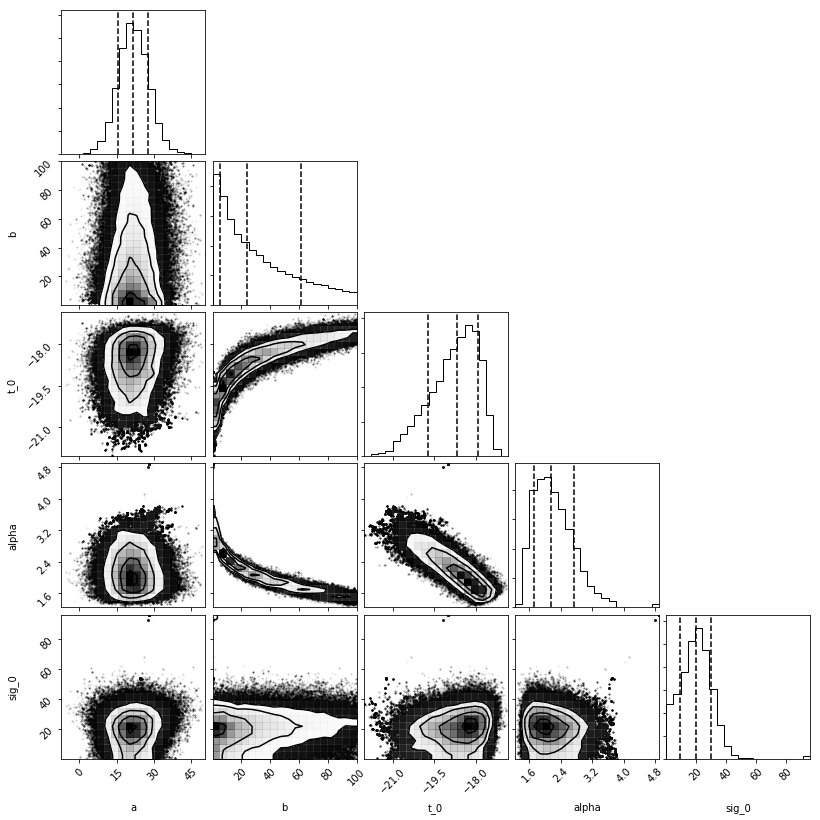

In [382]:
makeCorner(sampler_g, nburn, paramsNames)
plt.show()

In [383]:
print("g data results\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2]))

print("R data results\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_R[0], t_0_mc_R[1], t_0_mc_R[2], alpha_mc_R[0], alpha_mc_R[1], alpha_mc_R[2]))


g data results
       t_0 = -18.7899 +0.7841 -0.9853
       alpha = 2.2385 +0.5492 -0.4542

R data results
       t_0 = -18.7108 +0.6836 -0.9717
       alpha = 2.1469 +0.5411 -0.3683



In [418]:
#get maximum posterior parameters in g band
max_post_ind_g = np.argmax(sampler_g.lnprobability.flatten())
max_post_g = sampler_g.flatchain[max_post_ind_g]

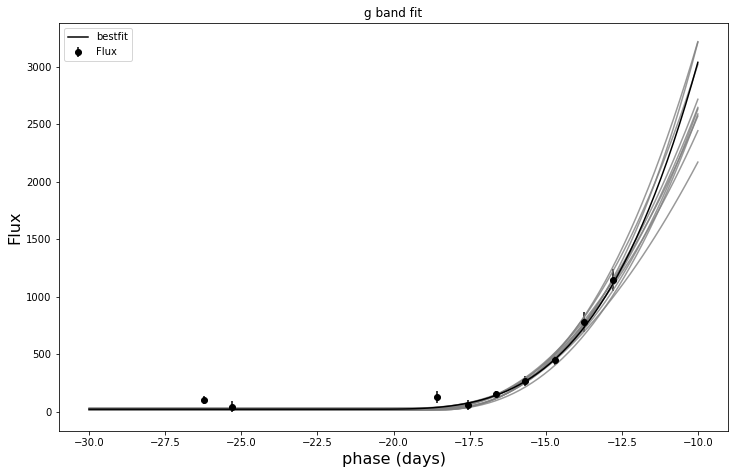

In [425]:
#plot maximum posterior model with data for g band
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.001)
ax = plt.subplot2grid([4, 1], [0, 0], rowspan=3)

times = np.where(g['phase'] > -30)
ax.errorbar(g['phase'].iloc[times],  g['Flux'].iloc[times], yerr=g['Fluxerr'].iloc[times], fmt='o',c='black' )
ax.set_xlabel('phase (days)', fontsize=16)
ax.set_ylabel('Flux', fontsize=16)


x_vals = np.linspace(-30, -10, 100)

def model(t, a, b, t_0, alpha):
    if(t > t_0):
        return a + (b*((t - t_0)**alpha))
    else:
        return a

#draw 5 random posterior samples
ints = np.random.randint(0, high=600000, size=10)

for i in ints:
    posterior = sampler_g.chain[:, nburn:, :].reshape((-1, len(paramsNames)))[i]
    y_vals = [model(t, *posterior[0:4])  for t in x_vals]
    ax.plot(x_vals, y_vals, c='grey', alpha=.8,)
    
    
    
#plot maximum posterior model

Y_vals = [model(t, *max_post_g[0:4]) for t in x_vals]



ax.plot(x_vals, Y_vals, c="black", label='bestfit')
ax.set_title('g band fit')
plt.legend()
plt.show()

In [427]:
#get maximum posterior parameters in R band
max_post_ind_R = np.argmax(sampler_R.lnprobability.flatten())
max_post_R = sampler_R.flatchain[max_post_ind_R]

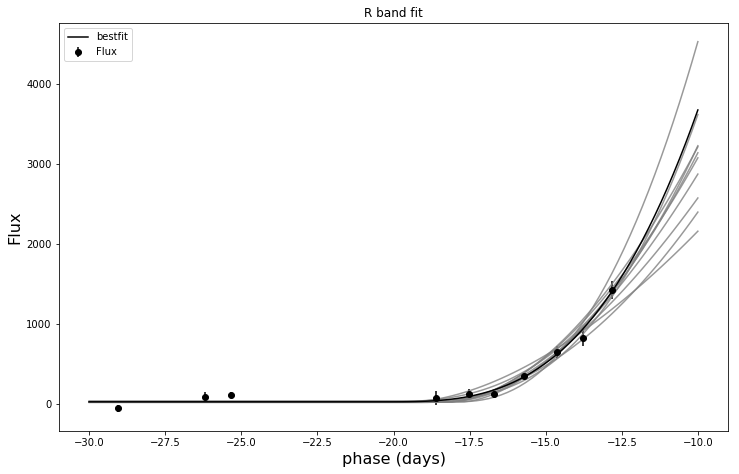

In [430]:
#plot maximum posterior model with data for R band
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.001)
ax = plt.subplot2grid([4, 1], [0, 0], rowspan=3)

times = np.where(R['phase'] > -30)
ax.errorbar(R['phase'].iloc[times],  R['Flux'].iloc[times], yerr=R['Fluxerr'].iloc[times], fmt='o',c='black' )
ax.set_xlabel('phase (days)', fontsize=16)
ax.set_ylabel('Flux', fontsize=16)


x_vals = np.linspace(-30, -10, 100)

def model(t, a, b, t_0, alpha):
    if(t > t_0):
        return a + (b*((t - t_0)**alpha))
    else:
        return a

#draw 5 random posterior samples
ints = np.random.randint(0, high=600000, size=10)

for i in ints:
    posterior = sampler_R.chain[:, nburn:, :].reshape((-1, len(paramsNames)))[i]
    y_vals = [model(t, *posterior[0:4])  for t in x_vals]
    ax.plot(x_vals, y_vals, c='grey', alpha=.8,)
    
    
    
#plot maximum posterior model
Y_vals = [model(t, *max_post_R[0:4]) for t in x_vals]


ax.plot(x_vals, Y_vals, c="black", label='bestfit')
ax.set_title('R band fit')
plt.legend()
plt.show()